# PUSULA TALENT ACADEMY DATA SCIENCE INTERN CASE STUDY

## Kütüphane Tanımları, Veri Yükleme, Kontroller

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode
import re 
from sklearn.preprocessing import LabelEncoder

Analiz ve düzenleme işlemleri sırasında gerekli olacak bütün kütüphanelerin tanımlamasını ortak alanda yapıyorum.

In [2]:
df = pd.read_excel('files/Talent_Academy_Case_DT_2025.xlsx')
df.head(5)

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,Kadın,0 Rh+,Türkiye,"Becker Musküler Distrofisi, Hiportiroidizm, Ka...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",TOZ,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika
1,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika
2,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika
3,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,5 Dakika
4,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika


Excel dosyasını okuyorum ve sonrasında tabloyu gözlemlemek amaçlı ilk 5 satırı output olarak yansıtıyorum.

In [3]:
df.shape

(2235, 13)

Excelden aldığımız veriler yönergede belirtilen ölçüler ile uyumlu.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HastaNo          2235 non-null   int64 
 1   Yas              2235 non-null   int64 
 2   Cinsiyet         2066 non-null   object
 3   KanGrubu         1560 non-null   object
 4   Uyruk            2235 non-null   object
 5   KronikHastalik   1624 non-null   object
 6   Bolum            2224 non-null   object
 7   Alerji           1291 non-null   object
 8   Tanilar          2160 non-null   object
 9   TedaviAdi        2235 non-null   object
 10  TedaviSuresi     2235 non-null   object
 11  UygulamaYerleri  2014 non-null   object
 12  UygulamaSuresi   2235 non-null   object
dtypes: int64(2), object(11)
memory usage: 227.1+ KB


Sütun isim ve sayıları yönerge ile uyuşuyor.  

"HastaNo" ve "Yas" verileri int veri türüne sahip.  

"TedaviSuresi" ve "UygulamaSuresi" verilerinin int veri türüne çevrilmesi gerekiyor.  
Veriyi incelediğimiz zaman sonlarında bulunan "Dakika" ve "Seans" ifadelerini kaldırıp veri türünü değiştirmek yeterli olacaktır.

"Cinsiyet", "KanGrubu", "KaronikHastalik", "Bolum", "Alerji", "Tanilar" ve "UygulamaYerleri" sütunlarında eksik veriler var.  
Bu sütunlar üzerine işlemler yaparken eksik verilere dikkat etmek gerekiyor.

In [5]:
df.duplicated(subset="HastaNo")

0       False
1       False
2        True
3        True
4        True
        ...  
2230     True
2231     True
2232    False
2233     True
2234     True
Length: 2235, dtype: bool

HastaNo değerinin tekrar ettiği yerler var.  
Yani bazı hastaların birden fazla işlem kaydı var.  
HastaNo değeri ID benzeri bir anlama sahip değil bu veri seti özelinde.

## Temizlik (Standartlaştırma ve Tip Düzenleme)

In [6]:
def split_and_clean(cell):
    if pd.isnull(cell):
        return []
    turkish_to_english = str.maketrans({
        'ç': 'c', 'ğ': 'g', 'ı': 'i', 'ö': 'o', 'ş': 's', 'ü': 'u',
        'Ç': 'C', 'Ğ': 'G', 'İ': 'I', 'Ö': 'O', 'Ş': 'S', 'Ü': 'U'
    })
    temp_cell = str(cell).translate(turkish_to_english)
    return [
        unidecode(re.sub(r"[^a-zA-Z0-9 ]", "", item.strip().lower()))
        for item in temp_cell.split(",")
        if item.strip() != ""
    ]

Bu fonksiyon, bir hücredeki metin verilerini ayrıştırarak temizlemek ve standart bir formata dönüştürmek için kullanılır. Özellikle Türkçe karakterlerin İngilizce karşılıklarına çevrilmesi, özel karakterlerin kaldırılması ve küçük harfe dönüştürme işlemleri gerçekleştirilir. Sırasıyla yapılan işlemler şu şekildedir:

1. **Boş Hücrelerin Kontrolü**:  
   - Eğer hücredeki değer `NaN` ise, fonksiyon boş bir liste (`[]`) döndürür.

2. **Türkçe Karakterlerin İngilizce Karşılıklarına Çevrilmesi**:  
   - `str.maketrans` yöntemiyle Türkçe karakterler (örneğin, "ç", "ğ", "ı") İngilizce karşılıklarına (örneğin, "c", "g", "i") çevrilir.

3. **Metnin Temizlenmesi**:  
   - `re.sub` kullanılarak metindeki özel karakterler ve harf/digit olmayan ifadeler kaldırılır.
   - Metin küçük harfe dönüştürülür ve baştaki/sondaki boşluklar temizlenir.

4. **Metnin Ayrıştırılması**:  
   - Hücredeki metin, virgül (`,`) karakterine göre ayrıştırılarak bir listeye dönüştürülür.

5. **Boş Elemanların Filtrelenmesi**:  
   - Listeye eklenen elemanlar arasında boş olanlar filtrelenir.

In [7]:
pd.set_option('display.max_columns', None)

Tabloları display ederken bütün sütunları inceleyebilmek için max_columns komudu çalıştırıyorum

### KronikHastalik Sütunu Veri Düzenleme ve One-Hot Encoding İşlemi

In [8]:
df["KronikHastalik"] = df["KronikHastalik"].apply(split_and_clean)
all_diseases = [disease for sublist in df["KronikHastalik"] for disease in sublist]
disease_counts = pd.Series(all_diseases).value_counts()

Bu kod, "KronikHastalik" sütunundaki verileri temizler, listeye dönüştürür ve her bir hastalığın frekansını hesaplar. Sırasıyla yapılan işlemler şu şekildedir:

1. **Veri Temizleme ve Listeye Dönüştürme:**
   - `split_and_clean` fonksiyonu kullanılarak, "KronikHastalik" sütunundaki veriler temizlenir ve liste formatına dönüştürülür. Bu işlem, Türkçe karakterlerin İngilizce karşılıklarına çevrilmesini, özel karakterlerin kaldırılmasını ve metinlerin küçük harfe dönüştürülmesini içerir.

2. **Tüm Hastalıkları Tek Bir Listeye Toplama:**
   - "KronikHastalik" sütunundaki alt listeler düzleştirilerek (`all_diseases`), tüm hastalıklar tek bir listeye dönüştürülür.

3. **Hastalık Frekanslarının Hesaplanması:**
   - `pd.Series(all_diseases).value_counts()` kullanılarak, her bir hastalığın kaç kez tekrarlandığı hesaplanır. Bu işlem, hastalıkların frekanslarını içeren bir pandas serisi (`disease_counts`) oluşturur.

Bu kod, kronik hastalıkların dağılımını analiz etmek ve hangi hastalıkların daha yaygın olduğunu belirlemek için attığımız temel adımdır.

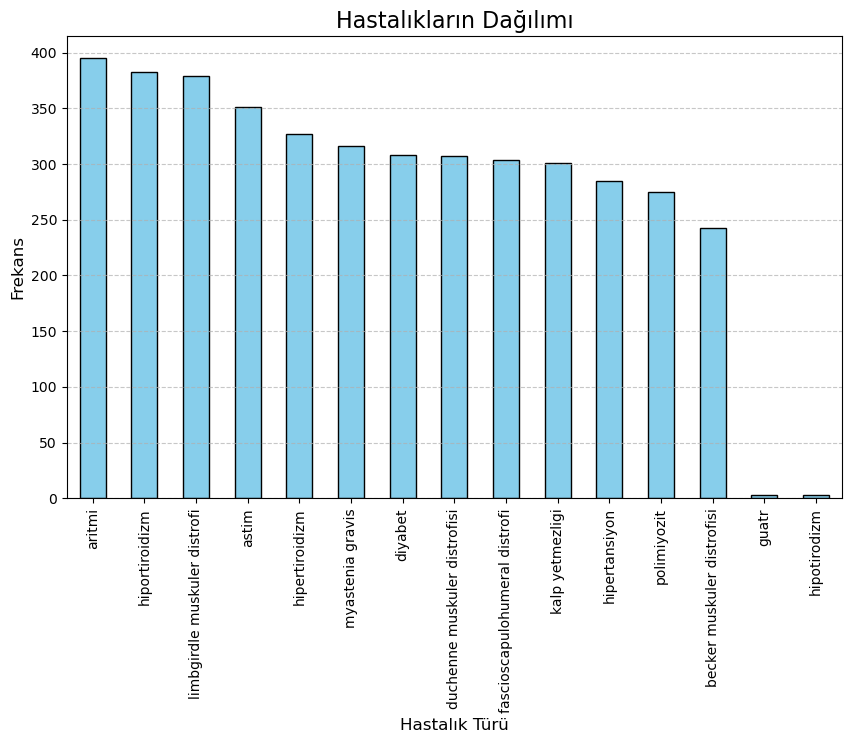

In [9]:
plt.figure(figsize=(10, 6))
disease_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Hastalıkların Dağılımı", fontsize=16)
plt.xlabel("Hastalık Türü", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Elimizdeki verilerde "guatr" ve "hipotirodizm" gibi bazı kategorilerde yeterli veri bulunmadığından, bu kategorileri "DiğerKronikHastaliklar" başlığı altında birleştirerek sütun kalabalığını önlemeyi hedefliyoruz. 

Bu işlemi daha genel ve ileriye dönük olarak kullanışlı hale getirmek için, ortalamanın altında sayıya sahip olan tüm kategorileri otomatik olarak "diğer" olarak adlandıracak bir yöntem belirliyoruz. Bu sayede, veri setinde daha düzenli ve anlamlı bir yapı oluşturulacaktır.

In [10]:
threshold = disease_counts.mean()
rare_diseases = disease_counts[disease_counts < threshold].index
df["KronikHastalik"] = df["KronikHastalik"].apply(
    lambda x: ["DiğerKronikHastaliklar" if disease in rare_diseases else disease for disease in x]
)

Bu kod, kronik hastalıkların frekansına göre nadir görülen hastalıkları belirler ve bu hastalıkları "DiğerKronikHastaliklar" adı altında gruplar. Sırasıyla yapılan işlemler şu şekildedir:
1. **Eşik Değerin Belirlenmesi:**
   - Hastalıkların frekanslarının ortalaması (`disease_counts.mean()`) eşik değer olarak belirlenir. Bu eşik değer, bir hastalığın "nadir" olarak kabul edilip edilmeyeceğini belirlemek için kullanılır.

2. **Nadir Hastalıkların Tanımlanması:**
   - Frekansı eşik değerin altında kalan hastalıklar, `rare_diseases` olarak etiketlenir.

3. **Nadir Hastalıkların Gruplandırılması:**
   - "KronikHastalik" sütunundaki her bir hastalık kontrol edilir. Eğer bir hastalık `rare_diseases` listesinde yer alıyorsa, bu hastalık "DiğerKronikHastaliklar" olarak değiştirilir. Bu işlem, `apply` ve bir `lambda` fonksiyonu kullanılarak gerçekleştirilir.

In [11]:
mlb = MultiLabelBinarizer()
KronikHastalikEncoded = pd.DataFrame(
    mlb.fit_transform(df["KronikHastalik"]),
    columns=mlb.classes_,
    index=df.index
)
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split(' '))

KronikHastalikEncoded.columns = [to_pascal_case(col) for col in KronikHastalikEncoded.columns]

df = df.join(KronikHastalikEncoded)
df = df.drop(columns=["KronikHastalik"]) 

Bu kod, "KronikHastalik" sütunundaki çoklu etiketli verileri binarize eder ve veri setine yeni sütunlar olarak ekler. Sırasıyla yapılan işlemler şu şekildedir:

1. **MultiLabelBinarizer Kullanımı:**
   - `MultiLabelBinarizer` kullanılarak, "KronikHastalik" sütunundaki çoklu etiketli veriler (örneğin, birden fazla hastalık içeren liste) binarize edilir.
   - Her bir hastalık için ayrı bir sütun oluşturulur ve hastalık bir bireyde varsa `1`, yoksa `0` olarak işaretlenir.

2. **Pascal Case Formatına Dönüştürme:**
   - Yeni oluşturulan sütun adları, daha okunabilir bir format olan **Pascal Case** formatına dönüştürülür. Örneğin, "diğer kronik hastalıklar" sütun adı "DiğerKronikHastalıklar" olarak değiştirilir.

3. **Yeni Sütunların Veri Setine Eklenmesi:**
   - Binarize edilmiş hastalık sütunları (`KronikHastalikEncoded`), orijinal veri setine (`df`) eklenir.

4. **Eski "KronikHastalik" Sütununun Kaldırılması:**
   - Orijinal "KronikHastalik" sütunu, artık binarize edilmiş sütunlar eklendiği için veri setinden kaldırılır.

Bu işlem, çoklu etiketli kategorik verileri modelleme için uygun hale getirir ve sütun adlarını daha okunabilir bir formata dönüştürerek veri setinin düzenini iyileştirir.

In [12]:
df.sample(5)

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis
1880,145469,38,Erkek,NaN,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","Polen,Yer Fıstığı","DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE,Boyun ağrısı",Boyun,22 Seans,Boyun,20 Dakika,0,0,0,0,0,0,0,0,0,0,0,0
1123,145331,41,Erkek,A Rh+,Türkiye,Ortopedi Ve Travmatoloji,NaN,Femurun longitudinal redüksiyon defekti,Kemik uzatma op lusu,4 Seans,NaN,10 Dakika,1,0,0,1,0,0,0,0,1,0,0,0
1675,145432,37,Erkek,NaN,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Toz,Kondromalazia patella,Kondromalazi patella,15 Seans,Diz,5 Dakika,0,0,0,0,0,0,0,0,0,0,0,0
2086,145509,41,Erkek,0 Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Polen,"İntervertebral disk bozuklukları, tanımlanmamı...",Dorsalji+ radikülopati,15 Seans,Bel,20 Dakika,1,0,0,1,0,0,0,0,0,0,0,0
790,145274,40,Kadın,0 Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"İntervertebral disk bozuklukları, tanımlanmamış",İV DİSK BOZUKLUĞU-BEL,15 Seans,Bel,20 Dakika,0,1,0,0,0,0,0,0,0,0,0,0


### Alerji Sütunu Veri Düzenleme ve One-Hot Encoding İşlemi

In [13]:
df["Alerji"].value_counts()

Alerji
Polen                198
POLEN                134
Toz                  119
ARVELES,CORASPIN     102
Sucuk                 91
NOVALGIN              90
Polen,Yer Fıstığı     83
TOZ                   74
SUCUK                 73
Novalgin              49
GRİPİN                47
Volteren              30
Voltaren              26
GRIPIN                22
VOLTAREN              19
POLEN,TOZ             13
VOLTAREN,Polen        11
Toz,TOZ                9
TOZ,Novalgin           7
Polen,NOVALGIN         7
Novalgin,Polen         6
TOZ,VOLTAREN           5
Voltaren,POLEN         5
Polen,GRIPIN           5
POLEN,Voltaren         5
NOVALGIN,Polen         5
VOLTAREN,POLEN         5
Volteren,GRİPİN        5
TOZ,POLEN              5
Polen,TOZ              5
Novalgin,Sucuk         5
SUCUK,GRIPIN           5
NOVALGIN,Novalgin      5
Polen,Toz              5
VOLTAREN,Toz           5
Polen,Voltaren         5
TOZ,GRİPİN             3
POLEN,NOVALGIN         3
Name: count, dtype: int64

Veri setinde aşağıdaki çakışmalar var:

- "voltaren" ve "volteren"
- "gripin" ve "gri̇pi̇n"

Bu çakışmaları gidermek için `replace` yöntemi kullanılarak aynı ifadeler birleştirilmektedir. Ayrıca, eksik değerler ("NaN") yerine "Yok" yazılarak veri seti daha düzenli hale getirilmektedir.

In [14]:
df["Alerji"] = df["Alerji"].replace("", "Alerji Yok").fillna("Alerji Yok")
corrections = {
    "Volteren": "Voltaren",
    "VOLTAREN":  "Voltaren",
    "Gri̇pi̇n": "Gripin",
    "GRİPİN": "Gripin", 
}
df["Alerji"] = df["Alerji"].replace(corrections)

Aşağıdaki işlemler gerçekleştirilmiştir:

1. **Boş ve Eksik Değerlerin Düzeltilmesi**:  
   - "Alerji" sütunundaki boş değerler `replace` yöntemiyle "Alerji Yok" olarak değiştirilmiştir.
   - Eksik değerler (`NaN`) ise `fillna` yöntemiyle "Alerji Yok" olarak doldurulmuştur.

2. **Veri Çakışmalarının Düzeltilmesi**:  
   - "Volteren" ve "VOLTAREN" ifadeleri "Voltaren" olarak düzeltilmiştir.
   - "Gri̇pi̇n" ve "GRİPİN" ifadeleri "Gripin" olarak düzeltilmiştir.

In [15]:
df["Alerji"] = df["Alerji"].apply(split_and_clean)
all_alerrgies = [allergies for sublist in df["Alerji"] for allergies in sublist]
allergies_counts = pd.Series(all_alerrgies).value_counts()

Bu kod bloğu, bir veri setindeki "Alerji" sütununda yer alan verileri temizlemek, ayrıştırmak ve her bir alerjinin kaç kez tekrarlandığını analiz etmek için kullanılmıştır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Alerji Verilerinin Ayrıştırılması ve Temizlenmesi**:  
   - `apply(split_and_clean)` yöntemiyle "Alerji" sütunundaki veriler ayrıştırılmış ve temizlenmiştir. Bu işlem, bir hücrede birden fazla alerji varsa bunları liste haline getirmiştir.

2. **Tüm Alerji Verilerinin Birleştirilmesi**:  
   - Ayrıştırılan alt listeler birleştirilerek tüm alerjilerin yer aldığı tek bir liste (`all_alerrgies`) oluşturulmuştur.

3. **Alerji Frekanslarının Hesaplanması**:  
   - `pd.Series(all_alerrgies).value_counts()` yöntemiyle her bir alerjinin kaç kez tekrarlandığı hesaplanmış ve frekans analizi yapılmıştır.


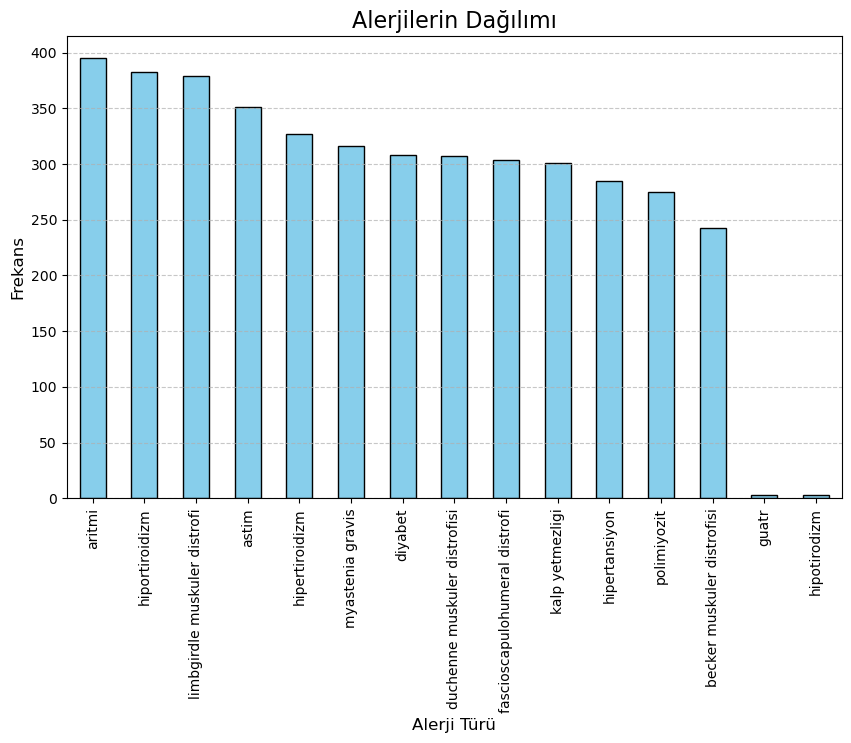

In [16]:
plt.figure(figsize=(10, 6))
disease_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Alerjilerin Dağılımı", fontsize=16)
plt.xlabel("Alerji Türü", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
pd.Series(all_diseases).value_counts()

aritmi                           395
hiportiroidizm                   383
limbgirdle muskuler distrofi     379
astim                            351
hipertiroidizm                   327
myastenia gravis                 316
diyabet                          308
duchenne muskuler distrofisi     307
fascioscapulohumeral distrofi    304
kalp yetmezligi                  301
hipertansiyon                    285
polimiyozit                      275
becker muskuler distrofisi       243
guatr                              3
hipotirodizm                       3
Name: count, dtype: int64

In [18]:
threshold = allergies_counts.mean()
rare_allergies = allergies_counts[allergies_counts < threshold].index
df["Alerji"] = df["Alerji"].apply(
    lambda x: ["Diğer Alerjiler" if allergies in rare_allergies and allergies != "Yok" else allergies for allergies in x]
)

Bu kod bloğu, veri setindeki nadir görülen alerjileri tespit ederek, bunları "Diğer Alerjiler" başlığı altında birleştirmek için kullanılmıştır. Bu işlem, veri setini daha düzenli ve analiz edilebilir hale getirmeyi amaçlamaktadır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Eşik Değerinin Belirlenmesi**:  
   - `allergies_counts.mean()` ile alerji frekanslarının ortalaması hesaplanmış ve bu değer eşik (threshold) olarak belirlenmiştir.

2. **Nadir Alerjilerin Tespiti**:  
   - Frekansı eşik değerinin altında kalan alerjiler `rare_allergies` listesine eklenmiştir.

3. **Nadir Alerjilerin Gruplandırılması**:  
   - `apply` yöntemi kullanılarak, "Alerji" sütunundaki nadir alerjiler "Diğer Alerjiler" olarak değiştirilmiştir. Ancak, "Yok" değeri bu işlemden hariç tutulmuştur.


In [19]:
mlb = MultiLabelBinarizer()
AlerjiEncoded = pd.DataFrame(
    mlb.fit_transform(df["Alerji"]),
    columns=mlb.classes_,
    index=df.index
)
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split(' '))

AlerjiEncoded.columns = [to_pascal_case(col) for col in AlerjiEncoded.columns]

df = df.join(AlerjiEncoded)
df = df.drop(columns=["Alerji"]) 

Bu kod bloğu, veri setindeki "Alerji" sütununu çoklu etiket binarizasyonu (multi-label binarization) yöntemiyle dönüştürerek, her bir alerji türünü ayrı bir sütun olarak temsil etmeyi amaçlamaktadır. Ayrıca, sütun adları PascalCase formatına dönüştürülmüş ve orijinal "Alerji" sütunu veri setinden kaldırılmıştır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Çoklu Etiket Binarizasyonu**:  
   - `MultiLabelBinarizer` kullanılarak "Alerji" sütunundaki her bir alerji türü için ayrı bir sütun oluşturulmuş ve değerler 0 (yok) veya 1 (var) olarak kodlanmıştır.

2. **PascalCase Formatına Dönüştürme**:  
   - `to_pascal_case` fonksiyonu tanımlanarak, sütun adları PascalCase formatına dönüştürülmüştür (örneğin, "Diğer Alerjiler" → "DiğerAlerjiler").

3. **Yeni Sütunların Veri Setine Eklenmesi**:  
   - Binarize edilmiş sütunlar (`AlerjiEncoded`) orijinal veri setine eklenmiştir.

4. **Orijinal "Alerji" Sütununun Kaldırılması**:  
   - Artık gereksiz hale gelen "Alerji" sütunu veri setinden kaldırılmıştır.


In [20]:
df.sample(5)

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,Bolum,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz
1576,145414,48,Erkek,NaN,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","DORSALJİ,, DİĞER, SERVİKAL BÖLGE,DORSALJİ, DİĞ...",Dorsalji -Boyun+trapez,15 Seans,Boyun,20 Dakika,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0
1550,145409,43,Erkek,B Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE",Dorsalji 1,15 Seans,Bel,20 Dakika,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0
1973,145484,34,Kadın,NaN,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",El bileği ve el düzeyinde baş parmak ekstansör...,1. Parmak CMC eklem ağrısı,15 Seans,Sol El Bilek Bölgesi,15 Dakika,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0
937,145303,37,Kadın,A Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","İntervertebral disk bozuklukları, tanımlanmamış",İV DİSK BOZUKLUĞU-BEL,15 Seans,Bel,20 Dakika,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
938,145303,37,Kadın,A Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","İntervertebral disk bozuklukları, tanımlanmamış",İV DİSK BOZUKLUĞU-BEL,15 Seans,Bel,5 Dakika,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Bolum Sütunu Veri Düzenleme ve One-Hot Encoding İşlemi

In [21]:
df["Bolum"].value_counts()

Bolum
Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi    2045
Ortopedi Ve Travmatoloji                            88
İç Hastalıkları                                     32
Nöroloji                                            17
Kardiyoloji                                         11
Göğüs Hastalıkları                                   8
Laboratuar                                           7
Genel Cerrahi                                        6
Tıbbi Onkoloji                                       6
Kalp Ve Damar Cerrahisi                              4
Name: count, dtype: int64

In [22]:
df["Bolum"] = df["Bolum"].apply(split_and_clean)
all_departments = [departments for sublist in df["Bolum"] for departments in sublist]
departments_counts = pd.Series(all_departments).value_counts()

Bu kod bloğu, veri setindeki "Bolum" sütununda yer alan verileri temizlemek, ayrıştırmak ve her bir bölümün kaç kez tekrarlandığını analiz etmek için kullanılmıştır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Bölüm Verilerinin Ayrıştırılması ve Temizlenmesi**:  
   - `apply(split_and_clean)` yöntemi kullanılarak "Bolum" sütunundaki veriler ayrıştırılmış ve temizlenmiştir. Bu işlem, bir hücrede birden fazla bölüm varsa bunları liste haline getirmiştir.

2. **Tüm Bölüm Verilerinin Birleştirilmesi**:  
   - Ayrıştırılan alt listeler birleştirilerek tüm bölümlerin yer aldığı tek bir liste (`all_departments`) oluşturulmuştur.

3. **Bölüm Frekanslarının Hesaplanması**:  
   - `pd.Series(all_departments).value_counts()` yöntemiyle her bir bölümün kaç kez tekrarlandığı hesaplanmış ve frekans analizi yapılmıştır.


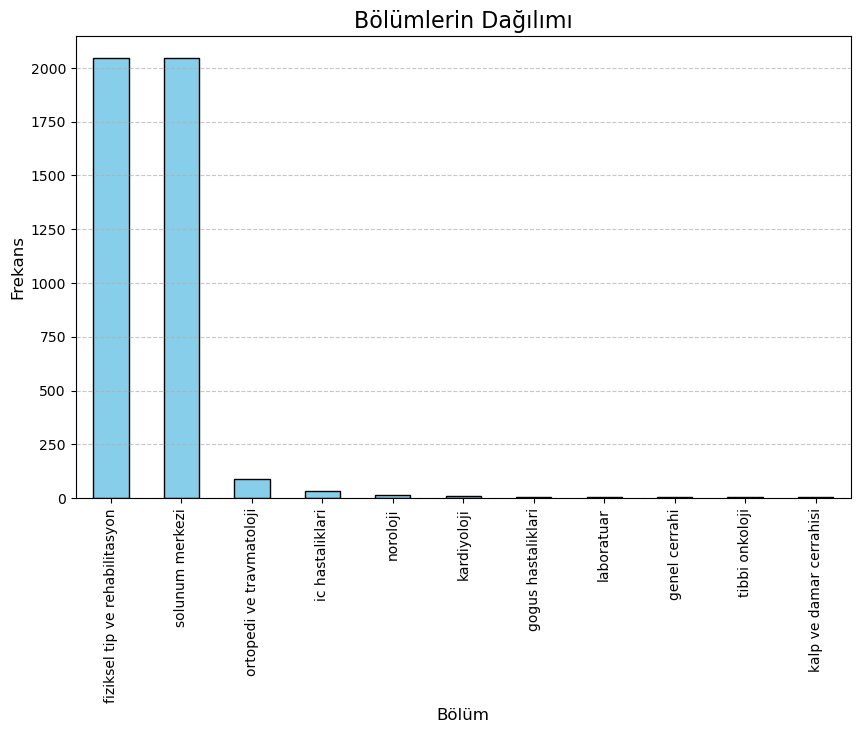

In [23]:
plt.figure(figsize=(10, 6))
departments_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Bölümlerin Dağılımı", fontsize=16)
plt.xlabel("Bölüm", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Bölüm bilgisi verinin genelinde bir farkındalık yaratacak seviyede değil.

In [24]:
df["Bolum"] = df["Bolum"].replace("", "Bolum Bilinmiyor").fillna("Alerji Bilinmiyor")

Boş bırakılan veya "NaN" olarak gelen hücreler için replace ve fillna fonksiyonlarını kullanıyorum.

In [25]:
threshold = departments_counts.mean()
rare_departments = departments_counts[departments_counts < threshold].index
df["Bolum"] = df["Bolum"].apply(
    lambda x: ["Diğer Bolumler" if departments in rare_departments and departments != "Yok" else departments for departments in x]
)
mlb = MultiLabelBinarizer()
BolumEncoded = pd.DataFrame(
    mlb.fit_transform(df["Bolum"]),
    columns=mlb.classes_,
    index=df.index
)
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split(' '))

BolumEncoded.columns = [to_pascal_case(col) for col in BolumEncoded.columns]

df = df.join(BolumEncoded)
df = df.drop(columns=["Bolum"]) 

Bu kod bloğu, veri setindeki "Bolum" sütununda nadir görülen bölümleri tespit ederek "Diğer Bolumler" başlığı altında birleştirmek ve ardından bu sütunu çoklu etiket binarizasyonu yöntemiyle dönüştürmek için kullanılmıştır. Ayrıca, sütun adları PascalCase formatına dönüştürülmüş ve orijinal "Bolum" sütunu veri setinden kaldırılmıştır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Eşik Değerinin Belirlenmesi**:  
   - `departments_counts.mean()` ile bölüm frekanslarının ortalaması hesaplanmış ve bu değer eşik (threshold) olarak belirlenmiştir.

2. **Nadir Bölümlerin Tespiti**:  
   - Frekansı eşik değerinin altında kalan bölümler `rare_departments` listesine eklenmiştir.

3. **Nadir Bölümlerin Gruplandırılması**:  
   - `apply` yöntemi kullanılarak, "Bolum" sütunundaki nadir bölümler "Diğer Bolumler" olarak değiştirilmiştir. Ancak, "Yok" değeri bu işlemden hariç tutulmuştur.

4. **Çoklu Etiket Binarizasyonu**:  
   - `MultiLabelBinarizer` kullanılarak "Bolum" sütunundaki her bir bölüm için ayrı bir sütun oluşturulmuş ve değerler 0 (yok) veya 1 (var) olarak kodlanmıştır.

5. **PascalCase Formatına Dönüştürme**:  
   - `to_pascal_case` fonksiyonu ile sütun adları PascalCase formatına dönüştürülmüştür (örneğin, "Diğer Bolumler" → "DiğerBolumler").

6. **Yeni Sütunların Veri Setine Eklenmesi**:  
   - Binarize edilmiş sütunlar (`BolumEncoded`) orijinal veri setine eklenmiştir.

7. **Orijinal "Bolum" Sütununun Kaldırılması**:  
   - Artık gereksiz hale gelen "Bolum" sütunu veri setinden kaldırılmıştır.


In [26]:
df.head(5)

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi
0,145134,60,Kadın,0 Rh+,Türkiye,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1
1,145135,28,Erkek,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1
2,145135,28,Erkek,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1
3,145135,28,Erkek,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,5 Dakika,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1
4,145135,28,Erkek,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1


### TedaviSuresi ve UygulamaSuresi Verilerini Sayısala Çevirme

In [27]:
df["TedaviSuresi"] = df["TedaviSuresi"].str.extract(r'(\d+)').astype(int)
df["UygulamaSuresi"] = df["UygulamaSuresi"].str.extract(r'(\d+)').astype(int)
df.sample(5)

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi
1347,145370,21,Erkek,NaN,Türkiye,"İntervertebral disk bozuklukları, tanımlanmamış",Dorsalji 1,15,Bel,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
2086,145509,41,Erkek,0 Rh+,Türkiye,"İntervertebral disk bozuklukları, tanımlanmamı...",Dorsalji+ radikülopati,15,Bel,20,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
2109,145513,73,Kadın,NaN,Türkiye,Radikülopati,İV DİSK BOZUKLUĞU-BEL,15,Bel,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1
369,145201,53,Kadın,A Rh+,Türkiye,El bileği ve el düzeyinde baş parmak ekstansör...,Algonörodistrofi Sol el,15,Sol El Bilek Bölgesi,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1808,145457,45,Erkek,NaN,Türkiye,"DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE",İV DİSK BOZUKLUĞU-BEL,15,Bel,20,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1


Bu kod bloğu, veri setindeki "TedaviSuresi" ve "UygulamaSuresi" sütunlarında yer alan metinlerden sayısal değerleri çıkararak bu sütunları tam sayı (integer) formatına dönüştürmeyi amaçlamaktadır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Sayısal Değerlerin Çıkarılması**:  
   - `str.extract(r'(\d+)')` yöntemi kullanılarak, "TedaviSuresi" ve "UygulamaSuresi" sütunlarındaki metinlerden yalnızca sayısal değerler çıkarılmıştır. Bu işlem, düzenli ifadeler (regex) kullanılarak gerçekleştirilmiştir.

2. **Veri Tipinin Dönüştürülmesi**:  
   - Çıkarılan sayısal değerler `astype(int)` yöntemiyle tam sayı formatına dönüştürülmüştür.

3. **Örnekleme**:  
   - `df.sample(5)` ile veri setinden rastgele 5 örnek alınarak işlemlerin sonucu kontrol edilmiştir.


### Yaş Gruplarının Oluşturulması

In [28]:
bins = [0, 18, 35, 60, 100]
labels = ["Çocuk", "Genç", "Yetişkin", "Yaşlı"]
df["YasGrubu"] = pd.cut(df["Yas"], bins=bins, labels=labels, right=False)
df["YasGrubu"].value_counts()
df = df.drop(columns=["Yas"])


Bu kod bloğu, veri setindeki "Yas" sütunundaki yaş verilerini belirli aralıklara (gruplara) ayırarak kategorik bir değişken ("YasGrubu") oluşturmayı ve ardından orijinal "Yas" sütununu kaldırmayı amaçlamaktadır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Yaş Aralıklarının Tanımlanması**:  
   - `bins` listesi kullanılarak yaş gruplarını belirleyen sınırlar tanımlanmıştır:  
     - 0-18: "Çocuk"  
     - 18-35: "Genç"  
     - 35-60: "Yetişkin"  
     - 60-100: "Yaşlı"

2. **Kategorik Yaş Gruplarının Oluşturulması**:  
   - `pd.cut` yöntemi kullanılarak "Yas" sütunundaki değerler, tanımlanan yaş aralıklarına göre kategorilere ayrılmış ve "YasGrubu" sütunu oluşturulmuştur.  
   - `right=False` parametresi, aralıkların sağ tarafının açık (dahil değil) olmasını sağlamıştır.

3. **Yaş Gruplarının Frekanslarının Hesaplanması**:  
   - `df["YasGrubu"].value_counts()` ile her bir yaş grubundaki gözlem sayısı hesaplanmıştır.

4. **Orijinal "Yas" Sütununun Kaldırılması**:  
   - Artık gereksiz hale gelen "Yas" sütunu veri setinden kaldırılmıştır.


In [29]:
df.sample(5)

,HastaNo,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi,YasGrubu
1256,145354,Erkek,NaN,Türkiye,"Menisküs yırtığı, şimdiki,Diz (anterior) (post...",MENİSKÜS TAMİRİ,20,Diz,20,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,Yetişkin
1827,145460,Kadın,B Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKA...",Boyun-Trapezz,15,Boyun,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,Yetişkin
1427,145385,Kadın,NaN,Türkiye,"İntervertebral disk bozuklukları, tanımlanmamış",İV DİSK BOZUKLUĞU-BEL,15,Bel,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,Yetişkin
459,145219,Kadın,0 Rh+,Türkiye,"Omuzun darbe sendromu,İntervertebral disk bozu...",Dorsalji 1,15,Bel,20,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,Yaşlı
242,145175,Erkek,NaN,Türkiye,"DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE,DORSALJİ, D...",İV DİSK BOZUKLUĞU-BEL,15,Bel,5,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,Yetişkin


### Cinsiyet Bilgilerinin Düzenlenmesi

In [30]:
df["Cinsiyet"] = df["Cinsiyet"].fillna("Bilinmiyor")

Cinsiyet bilgisinde boş olan sütunları "Bilinmiyor" olarak dolduruyorum. 

In [31]:
df["Cinsiyet"].value_counts()

Cinsiyet
Kadın         1274
Erkek          792
Bilinmiyor     169
Name: count, dtype: int64

In [32]:
gender_codes = {'Kadın': 0, 'Erkek': 1, 'Bilinmiyor': 2}
encoder = LabelEncoder()
df["Cinsiyet"] = df["Cinsiyet"].map(gender_codes)
df.sample(5)

,HastaNo,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi,YasGrubu
1868,145467,1,NaN,Türkiye,"İntervertebral disk bozuklukları, tanımlanmamı...",servikal Disk Hernisi,15,Boyun,5,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,Yetişkin
47,145142,1,B Rh+,Türkiye,"Esansiyel (primer) hipertansiyon,Diyabetes mel...",Alt ekstremite atrofi-Bilateral,20,NaN,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,Yaşlı
2127,145517,1,NaN,Türkiye,"DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE",Dorsalji 1,15,Bel,20,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,Yetişkin
505,145228,2,A Rh+,Türkiye,Kalkaneal spur,Kalkaneal Spur-1,15,Sağ Ayak Bileği Bölgesi,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,Yetişkin
1660,145430,0,0 Rh+,Türkiye,"Patellofemoral bozukluklar,Eklem ağrısı",Gonartroz-Meniskopati,15,Diz,5,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,Yaşlı


Bu kod bloğu, veri setindeki "Cinsiyet" sütununda yer alan kategorik değerleri sayısal değerlere dönüştürerek makine öğrenimi modelleri için uygun hale getirmeyi amaçlamaktadır. Sırasıyla yapılan işlemler şu şekildedir: 

1. **Cinsiyet Kodlarının Tanımlanması**:  
   - `gender_codes` sözlüğü kullanılarak "Cinsiyet" sütunundaki kategorik değerler için sayısal kodlar atanmıştır:  
     - "Kadın" → 0  
     - "Erkek" → 1  
     - "Bilinmiyor" → 2  

2. **Kodlama İşlemi**:  
   - `map` yöntemi kullanılarak "Cinsiyet" sütunundaki değerler, `gender_codes` sözlüğüne göre sayısal değerlere dönüştürülmüştür.


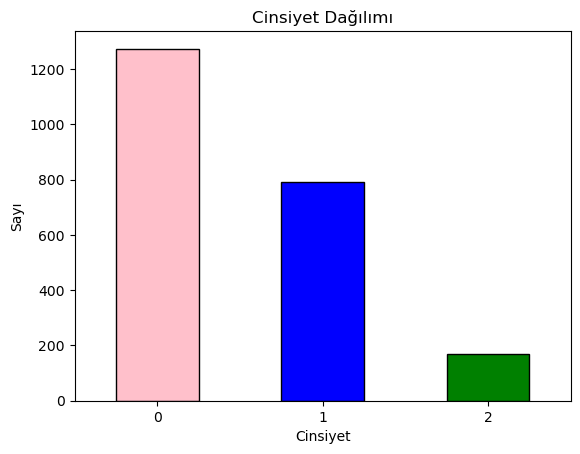

In [33]:
cinsiyet_sayilari = df['Cinsiyet'].value_counts()
cinsiyet_sayilari.plot(kind='bar', color=['pink', 'blue', 'green'], edgecolor='black')
plt.title('Cinsiyet Dağılımı')
plt.xlabel('Cinsiyet')
plt.ylabel('Sayı')
plt.xticks(rotation=0)
plt.show()

### Kan Grubu Bilgisinin Güncellenmesi

In [34]:
df["KanGrubu"] = df["KanGrubu"].fillna("Bilinmiyor")

Kan grupları içinde olan boş değerleri "Bilinmiyor" olarak güncelliyorum.

In [35]:
df["KanGrubu"].value_counts()

KanGrubu
Bilinmiyor    675
0 Rh+         579
A Rh+         540
B Rh+         206
AB Rh+         80
B Rh-          68
A Rh-          53
0 Rh-          26
AB Rh-          8
Name: count, dtype: int64

### UygulamaYerleri Bilgisinin Güncellenmesi

In [36]:
df["UygulamaYerleri"] = df["UygulamaYerleri"].apply(split_and_clean)
all_limbs = [limb for sublist in df["UygulamaYerleri"] for limb in sublist]
limb_counts = pd.Series(all_limbs).value_counts()

Bu kod bloğu, veri setindeki "UygulamaYerleri" sütununda yer alan verileri temizlemek, ayrıştırmak ve her bir uygulama yerinin kaç kez tekrarlandığını analiz etmek için kullanılmıştır. Sırasıyla yapılan işlemler şu şekildedir:
1. **Uygulama Yerlerinin Ayrıştırılması ve Temizlenmesi**:  
   - `apply(split_and_clean)` yöntemi kullanılarak "UygulamaYerleri" sütunundaki veriler ayrıştırılmış ve temizlenmiştir. Bu işlem, bir hücrede birden fazla uygulama yeri varsa bunları liste haline getirmiştir.

2. **Tüm Uygulama Yerlerinin Birleştirilmesi**:  
   - Ayrıştırılan alt listeler birleştirilerek tüm uygulama yerlerinin yer aldığı tek bir liste (`all_limbs`) oluşturulmuştur.

3. **Uygulama Yerlerinin Frekanslarının Hesaplanması**:  
   - `pd.Series(all_limbs).value_counts()` yöntemiyle her bir uygulama yerinin kaç kez tekrarlandığı hesaplanmış ve frekans analizi yapılmıştır.


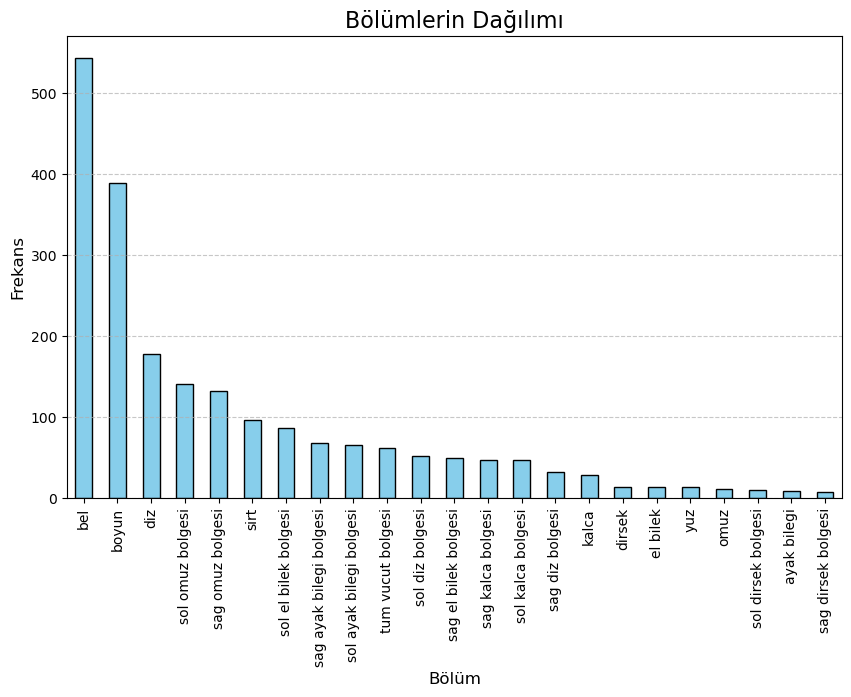

In [37]:
plt.figure(figsize=(10, 6))
limb_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Bölümlerin Dağılımı", fontsize=16)
plt.xlabel("Bölüm", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
df["UygulamaYerleri"] = df["UygulamaYerleri"].fillna("Uygulama Yerleri Bilinmiyor")

Boş olan hücreler için "Uygulama Yeri Bilinmiyor" bilgisi giriliyor.

In [39]:
threshold = limb_counts.mean()
rare_limbs = limb_counts[limb_counts < threshold].index
df["UygulamaYerleri"] = df["UygulamaYerleri"].apply(
    lambda x: ["Diğer UygulamaYerleri" if limb in rare_limbs and limb != "Yok" else limb for limb in x]
)
mlb = MultiLabelBinarizer()
UygulamaYerleriEncoded = pd.DataFrame(
    mlb.fit_transform(df["UygulamaYerleri"]),
    columns=mlb.classes_,
    index=df.index
)
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split(' '))

UygulamaYerleriEncoded.columns = [to_pascal_case(col) for col in UygulamaYerleriEncoded.columns]

df = df.join(UygulamaYerleriEncoded)
df = df.drop(columns=["UygulamaYerleri"]) 

Bu kod bloğu, veri setindeki "UygulamaYerleri" sütununda nadir görülen uygulama yerlerini tespit ederek "Diğer UygulamaYerleri" başlığı altında birleştirmek ve ardından bu sütunu çoklu etiket binarizasyonu yöntemiyle dönüştürmek için kullanılmıştır. Ayrıca, sütun adları PascalCase formatına dönüştürülmüş ve orijinal "UygulamaYerleri" sütunu veri setinden kaldırılmıştır. Sırasıyla yapılan işlemler şu şekildedir:

1. **Eşik Değerinin Belirlenmesi**:  
   - `limb_counts.mean()` ile uygulama yerlerinin frekanslarının ortalaması hesaplanmış ve bu değer eşik (threshold) olarak belirlenmiştir.

2. **Nadir Uygulama Yerlerinin Tespiti**:  
   - Frekansı eşik değerinin altında kalan uygulama yerleri `rare_limbs` listesine eklenmiştir.

3. **Nadir Uygulama Yerlerinin Gruplandırılması**:  
   - `apply` yöntemi kullanılarak, "UygulamaYerleri" sütunundaki nadir uygulama yerleri "Diğer UygulamaYerleri" olarak değiştirilmiştir. Ancak, "Yok" değeri bu işlemden hariç tutulmuştur.

4. **Çoklu Etiket Binarizasyonu**:  
   - `MultiLabelBinarizer` kullanılarak "UygulamaYerleri" sütunundaki her bir uygulama yeri için ayrı bir sütun oluşturulmuş ve değerler 0 (yok) veya 1 (var) olarak kodlanmıştır.

5. **PascalCase Formatına Dönüştürme**:  
   - `to_pascal_case` fonksiyonu ile sütun adları PascalCase formatına dönüştürülmüştür (örneğin, "Diğer UygulamaYerleri" → "DiğerUygulamaYerleri").

6. **Yeni Sütunların Veri Setine Eklenmesi**:  
   - Binarize edilmiş sütunlar (`UygulamaYerleriEncoded`) orijinal veri setine eklenmiştir.

7. **Orijinal "UygulamaYerleri" Sütununun Kaldırılması**:  
   - Artık gereksiz hale gelen "UygulamaYerleri" sütunu veri setinden kaldırılmıştır.


In [40]:
df.sample(5)

,HastaNo,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi,YasGrubu,DiğerUygulamayerleri,Bel,Boyun,Diz,SagOmuzBolgesi,Sirt,SolOmuzBolgesi
1080,145326,0,A Rh+,Türkiye,"Fibromiyalji , birden fazla yer,DORSALJİ, DİĞE...",Dorsalji -Boyun+trapez,15,20,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,Yetişkin,0,0,1,0,0,0,0
1612,145420,0,Bilinmiyor,Türkiye,"DORSALJİ, DİĞER, SERVİKOTORASİK BÖLGE,DORSALJİ...",Dorsalji -Boyun+trapez,15,20,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,0,0
2188,145528,0,0 Rh+,Türkiye,"DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE",Dorsalji-Bel,15,20,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,Genç,0,1,0,0,0,0,0
2043,145499,0,AB Rh+,Türkiye,"Kas bozuklukları, başka yerde sınıflanmış hast...",Alt ekstremite atrofi-Bilateral,15,20,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,Yaşlı,0,1,0,0,0,0,0
289,145185,1,0 Rh+,Türkiye,"Menisküs yırtığı, şimdiki",MENİSKÜS TAMİRİ,15,20,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,Yetişkin,0,0,0,1,0,0,0


### Uyruk Bilgisinin Güncellenmesi

In [41]:
df["Uyruk"].value_counts()

Uyruk
Türkiye       2173
Tokelau         27
Arnavutluk      13
Azerbaycan      12
Libya           10
Name: count, dtype: int64

In [42]:
df['Uyruk'] = df['Uyruk'].apply(lambda x: 'Türkiye' if x == 'Türkiye' else 'Diğer')
df.sample(5)

,HastaNo,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi,YasGrubu,DiğerUygulamayerleri,Bel,Boyun,Diz,SagOmuzBolgesi,Sirt,SolOmuzBolgesi
2198,145529,0,Bilinmiyor,Türkiye,"Spastik hemipleji,Multipl skleroz",Sağ hemipleji,20,20,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,1,Yetişkin,0,0,0,0,0,0,0
53,145143,1,B Rh-,Türkiye,Aşil tendon yaralanması,Aşil Rüptürü-1,15,5,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,Yetişkin,1,0,0,0,0,0,0
1830,145461,2,Bilinmiyor,Türkiye,Boyun ağrısı,Dorsalji -Boyun+trapez,15,20,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,Yetişkin,0,0,1,0,0,0,0
586,145240,1,A Rh-,Türkiye,"İntervertebral disk bozuklukları, tanımlanmamış",İV DİSK BOZUKLUĞU-BEL,15,20,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,Yetişkin,0,1,0,0,0,0,0
1961,145482,0,B Rh+,Türkiye,Omuzun darbe sendromu,Sol Omuz impingement,16,20,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,Yetişkin,0,0,0,0,0,0,1


Uyruk bilgisinde verileri Türkiye ve Diğer olarak iki gruba indiriliyor.

In [43]:
df["Uyruk"].value_counts()

Uyruk
Türkiye    2173
Diğer        62
Name: count, dtype: int64

In [44]:
df.shape

(2235, 35)

# Verinin Son Durumu

In [45]:
df.head(10)

,HastaNo,Cinsiyet,KanGrubu,Uyruk,Tanilar,TedaviAdi,TedaviSuresi,UygulamaSuresi,Diğerkronikhastaliklar,Aritmi,Astim,Diyabet,DuchenneMuskulerDistrofisi,FascioscapulohumeralDistrofi,Hipertansiyon,Hipertiroidizm,Hiportiroidizm,KalpYetmezligi,LimbgirdleMuskulerDistrofi,MyasteniaGravis,DiğerAlerjiler,AlerjiYok,Polen,Toz,DiğerBolumler,FizikselTipVeRehabilitasyon,SolunumMerkezi,YasGrubu,DiğerUygulamayerleri,Bel,Boyun,Diz,SagOmuzBolgesi,Sirt,SolOmuzBolgesi
0,145134,0,0 Rh+,Türkiye,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5,20,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,Yaşlı,1,0,0,0,0,0,0
1,145135,1,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,20,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,0,0
2,145135,1,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,20,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,1,0
3,145135,1,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,5,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,0,0
4,145135,1,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,20,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,1,0
5,145135,1,0 Rh+,Türkiye,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,20,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,Genç,0,0,1,0,0,0,0
6,145136,1,0 Rh+,Türkiye,Parapleji ve tetrapleji,Parapleji,10,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,Yaşlı,0,0,0,0,0,0,0
7,145136,1,0 Rh+,Türkiye,Parapleji ve tetrapleji,Parapleji,10,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,Yaşlı,0,0,0,0,0,0,0
8,145136,1,0 Rh+,Türkiye,Parapleji ve tetrapleji,Parapleji,10,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,Yaşlı,0,0,0,0,0,0,0
9,145137,0,0 Rh+,Türkiye,"Artroz, tanımlanmamış, el",El rehabilitasyonu,15,15,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,1,Yaşlı,1,0,0,0,0,0,0


In [46]:
df.shape

(2235, 35)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   HastaNo                       2235 non-null   int64   
 1   Cinsiyet                      2235 non-null   int64   
 2   KanGrubu                      2235 non-null   object  
 3   Uyruk                         2235 non-null   object  
 4   Tanilar                       2160 non-null   object  
 5   TedaviAdi                     2235 non-null   object  
 6   TedaviSuresi                  2235 non-null   int64   
 7   UygulamaSuresi                2235 non-null   int64   
 8   Diğerkronikhastaliklar        2235 non-null   int64   
 9   Aritmi                        2235 non-null   int64   
 10  Astim                         2235 non-null   int64   
 11  Diyabet                       2235 non-null   int64   
 12  DuchenneMuskulerDistrofisi    2235 non-null   in